In [338]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import butter, lfilter , filtfilt
import pandas as pd
import scipy as sp
import os
import sys
import seaborn as sb 
from matplotlib import cm

import biosppy.signals
import pickle


# Retrieve Data

In [336]:
##  retrieve tensors ##
file = open('tensor_dump.pkl', 'rb')
raw_data_to_tensor = pickle.load(file)
amplitude_data_to_tensor  = pickle.load(file)
muscles_to_tensor = pickle.load(file)
elecs_to_tensor = pickle.load(file)

file.close()

In [337]:
## retrieve muscle and elec names

df_electrodes = pd.read_csv("df_electrodes.csv")
df_muscles= pd.read_csv("df_muscles.csv")

# Set Functions

## Given a muscle name the data tensor and amplitudes tensor is returned

In [ ]:
## Make a function that given a muscle name, returns the data tensor and amplitudes tensor related to this muscle. ##
def return_data_for_muscle(muscle_name): # Input muscle_name Eg. "Vlat"

    # get:
    #raw data for specific muscle
    #amplitdue data for specific muscle
    #muscle_nr

    muscle_nr=df_muscles.index.where(df_muscles.muscle_name==muscle_name).dropna().astype(int)[0]
    data_tensor_muscle_i=raw_data_to_tensor[:,muscle_nr,:,:,:] #returns a tensor of size([16, 32, 11, 1404])
    amplitude_tensor_muslce_i=amplitude_data_to_tensor[:, muscle_nr, :] #returns a tensor of size([16, 32])
    print(f"will return all raw data for {muscle_nr}: {muscle_name}, and the amplitude data")
 
    return(data_tensor_muscle_i, amplitude_tensor_muslce_i, muscle_nr) 

   

In [ ]:
## check definition
data_tensor_muscle_i,amplitude_tensor_muslce_i =return_data_for_muscle("RRF")
# print(data_tensor_muscle_i.size())
print(amplitude_tensor_muslce_i[0][0])
# print(data_tensor_muscle_i[0]) #torch.Size([32, 11, 1404])

will return all raw data for 12 :RRF, and the amplitude data
tensor(nan)


## Given the muscle the maximum EMG value within the data is returned

In [318]:
# Make a function that finds for each muscle the maximum EMG value within the data, 
# saves the indeces and plots the trial with max emg value

def find_max_emg(muscle_name): # Input muscle_name Eg. "Vlat"
    
    # get:
    #raw data for specific muscle
    #amplitdue data for specific muscle
    #elec, amp, trial_nr of max emg value
    #max emg value
    #plot of trial with max emg

    elec_list=[]
    max_list=[]
    amp_index=[]
    trial_index=[]
    data_tensor_muscle_i, amplitude_tensor_muslce_i, muscle_nr =return_data_for_muscle(muscle_name)
    for elec in range (len(amplitude_data_to_tensor[:, 0, 0])): #loop through all the elecs

        # extract indeces where theres data for the amplitudes 
        df=pd.DataFrame(amplitude_tensor_muslce_i[elec, :])
        df=df.notna()
        idx_list=[]
        for idx  in range(len(df[0])):
            if df[0][idx] == True:
                idx_list.append(idx) # List with indeces for notna

        
 
        for amp_ind in idx_list:
            for trial in range(len(data_tensor_muscle_i[0, 0, :, 0])):
                if torch.isnan(data_tensor_muscle_i[elec, amp_ind, trial, 0])==False:
                    max=np.nanmax(data_tensor_muscle_i[elec, amp_ind, trial, :])

                    
                    max_list.append(max)
                    elec_list.append(elec)
                    amp_index.append(amp_ind)
                    trial_index.append(trial)
    
    #Save all the info in a df
    d = {'elec': elec_list, 'max_emg_value': max_list, "amplitude_ind": amp_index, "trial_index": trial_index}
    df = pd.DataFrame(data=d)
    
   #Get the max emg value for the muscle, and indeces 
    max_value=np.max(df["max_emg_value"])
    ind = np.where(df["max_emg_value"] == (np.max(df["max_emg_value"])))
    elec_of_max_value=df["elec"].iloc[ind[0][0]]
    amp_ind_max_value=df["amplitude_ind"].iloc[ind[0][0]]
    trial_ind_max_value=df["trial_index"].iloc[ind[0][0]]
    print(f"For muscle({muscle_nr}) {muscle_name} max EMG Value:{max_value} with electrode {int(elec_of_max_value)}, amplitude: {int(amp_ind_max_value)} and trial_nr:{trial_ind_max_value}")

    #Plot the trial with max emg
    plt.title(f"For muscle ({muscle_nr}) {muscle_name}, max emg signal:{max_value} was found in electrode: {int(elec_of_max_value)}, amplitude: {int(amp_ind_max_value)} and trial: {trial_ind_max_value}")
    plt.xlabel("Time")
    plt.plot(data_tensor_muscle_i[elec_of_max_value,amp_ind_max_value,trial_ind_max_value,:])

    return data_tensor_muscle_i,amplitude_tensor_muslce_i, int(elec_of_max_value), max_value, int(amp_ind_max_value)



will return all raw data for 12: RRF, and the amplitude data
For muscle(12) RRF max EMG Value:3.583035469055176 with electrode 12, amplitude: 21 and trial_nr:4


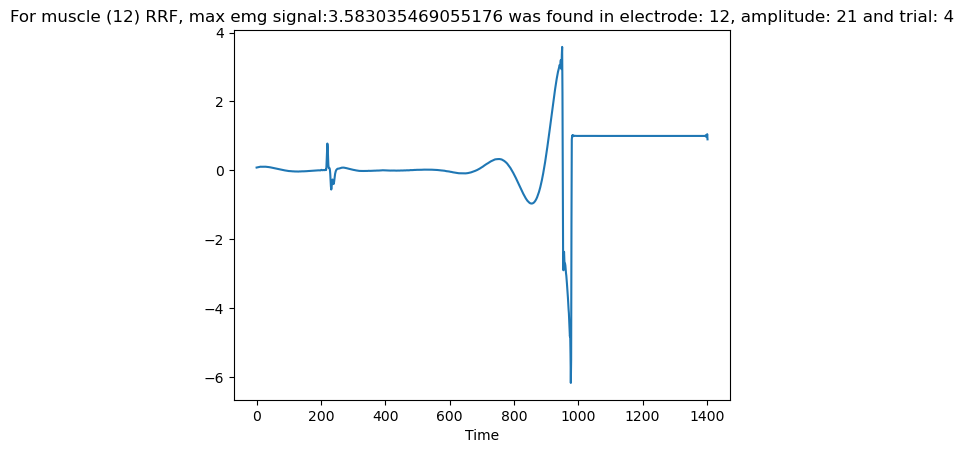

In [339]:
## Check function
data_tensor_muscle_i,amplitude_tensor_muslce_i, elec_of_max_value, max_value, amp_ind_max_value=find_max_emg("RRF")



## Make a function that receives a single EMG time series and computes its peak-to-peak time series.

In [342]:
# find window with emg values for a time series

# Determine onsets of EMG pulses. # Skips corrupted signal parts.??

# Parameters:	
# signal (array) – Input filtered EMG signal.
# sampling_rate (int, float, optional) – Sampling frequency (Hz).
# size (float, optional) – Detection window size (seconds).
# threshold (float, optional) – Detection threshold.
# Returns:	
# onsets (array) – Indices of EMG pulse onsets.

# biosppy.signals.emg.find_onsets(signal=raw_data_to_tensor[12,12,21,4,:], sampling_rate=1000.0, size=0.25, threshold=None) 
biosppy.signals.emg.find_onsets(signal=raw_data_to_tensor[12,12,21,4,:]) 


ReturnTuple(onsets=array([], dtype=int64))

In [348]:
np.array(raw_data_to_tensor[12,12,21,4,:])


array([0.08238404, 0.0846118 , 0.08438362, ..., 1.0508273 , 0.90098244,
              nan], dtype=float32)

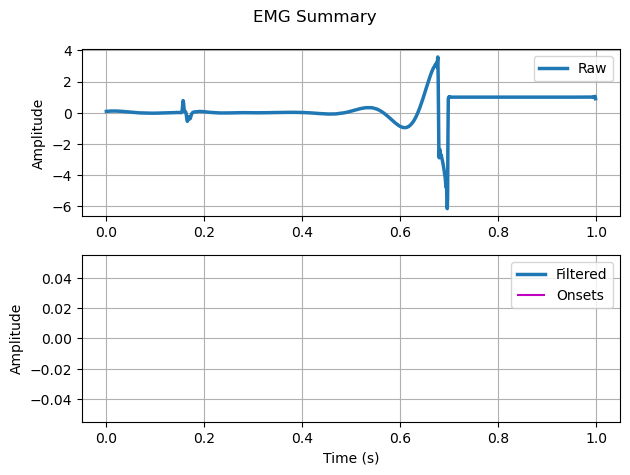

ReturnTuple(ts=array([0.00000000e+00, 7.12250712e-04, 1.42450142e-03, ...,
       9.97863248e-01, 9.98575499e-01, 9.99287749e-01]), filtered=array([nan, nan, nan, ..., nan, nan, nan]), onsets=array([], dtype=int64))

In [355]:

# Process a raw EMG signal and extract relevant signal features using default parameters. ??

# Parameters:	
# signal (array) – Raw EMG signal.
# sampling_rate (int, float, optional) – Sampling frequency (Hz).
# show (bool, optional) – If True, show a summary plot.
# Returns:	
# ts (array) – Signal time axis reference (seconds).
# filtered (array) – Filtered EMG signal.
# onsets (array) – Indices of EMG pulse onsets.


biosppy.signals.emg.emg(signal=np.array(raw_data_to_tensor[12,12,21,4,:]), sampling_rate=1404, show=True)
# biosppy.signals.emg.emg(signal=np.array(raw_data_to_tensor[12,12,21,4,:])) 

In [361]:
np.arange(5, 20)

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

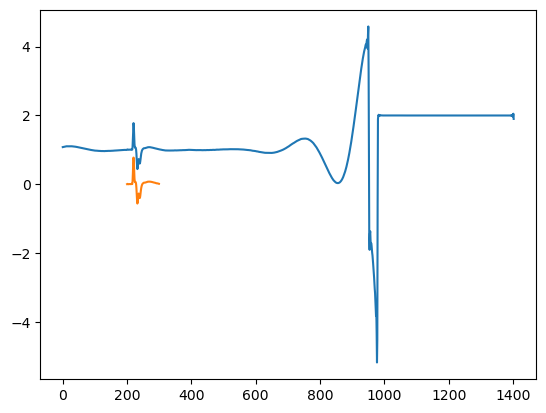

In [366]:
## Manually find how many TP are in a window
    # for now take 100

offset=1
init_art=200
end_art= 300
time_array_original=np.arange(0,len(raw_data_to_tensor[12,12,21,4,:]))
time_array_artifact=np.arange(init_art, end_art)
time_array = np.arange(1,1404+1)
plt.plot(time_array_original, np.array(raw_data_to_tensor[12,12,21,4,:])+offset)
plt.plot(time_array_artifact, np.array(raw_data_to_tensor[12,12,21,4,:][init_art:end_art ]))

In [393]:
# raw_data_to_tensor[12,12,21,4,:][0:20]
len(time_series_in_trial[13])
# 20 0.1060,

100

In [391]:
## 1.For one trial reorganise it into different windows
## 2.For every window find max pos and min neg
    #evt plot?
# get peak to peak value for every window
#restructure it into a fct.

tp_array=100 #amounts of timepoints in one array
total_time_serie=len(raw_data_to_tensor[12,12,21,4,:])
arrays_per_trial= total_time_serie//tp_array
time_series_in_trial= [0]*arrays_per_trial
t=0
for i in range(arrays_per_trial):
    
    time_series_in_trial[i]= raw_data_to_tensor[12,12,21,4,:][t:t+100] #not sure if it goes to hundred
    t+=100
print(time_series_in_trial)


[tensor([ 8.2384e-02,  8.4612e-02,  8.4384e-02,  8.9103e-02,  9.0417e-02,
         9.4288e-02,  9.4202e-02,  9.5657e-02,  9.6946e-02,  1.0071e-01,
         1.0433e-01,  1.0646e-01,  1.0659e-01,  1.0579e-01,  1.0514e-01,
         1.0493e-01,  1.0521e-01,  1.0592e-01,  1.0655e-01,  1.0655e-01,
         1.0604e-01,  1.0572e-01,  1.0613e-01,  1.0723e-01,  1.0835e-01,
         1.0863e-01,  1.0787e-01,  1.0685e-01,  1.0616e-01,  1.0538e-01,
         1.0407e-01,  1.0307e-01,  1.0323e-01,  1.0378e-01,  1.0309e-01,
         1.0079e-01,  9.8092e-02,  9.6260e-02,  9.5295e-02,  9.4277e-02,
         9.2670e-02,  9.0862e-02,  8.9320e-02,  8.7771e-02,  8.5742e-02,
         8.3524e-02,  8.1841e-02,  8.0727e-02,  7.9470e-02,  7.7556e-02,
         7.5003e-02,  7.2090e-02,  6.9291e-02,  6.7032e-02,  6.5132e-02,
         6.2957e-02,  6.0376e-02,  5.7935e-02,  5.6036e-02,  5.4247e-02,
         5.1840e-02,  4.8884e-02,  4.6342e-02,  4.4868e-02,  4.3977e-02,
         4.2713e-02,  4.0736e-02,  3.8386e-02,  3.

In [ ]:
#4. Make a function that receives a single EMG time series and computes its peak-to-peak time series.
def find_max_emg():
    print("Hello from a function")

# Run analysis